In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

/tmp/ipykernel_1502/83197244.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

backend used:  ibmq_belem


In [3]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [4]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [5]:
aer_sim = Aer.get_backend('aer_simulator')

In [6]:
n = 4

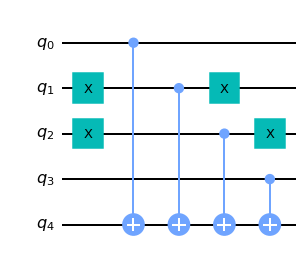

In [23]:
oracle_qc = dj_oracle('balanced', n)
oracle_qc.draw()

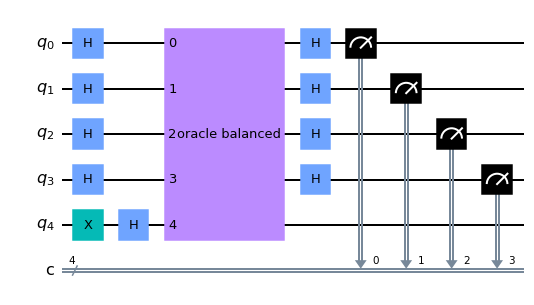

In [24]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

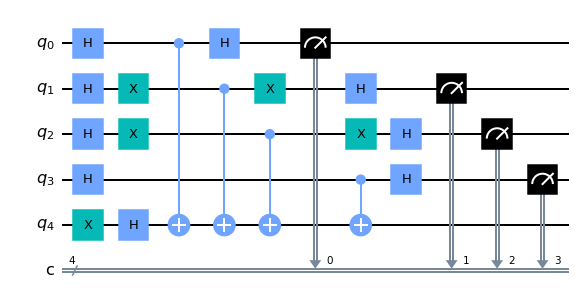

In [25]:
new_dj = dj_circuit.decompose('oracle balanced')
new_dj.draw()

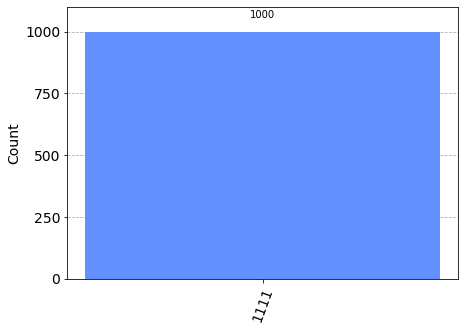

In [26]:
aer_job = execute(dj_circuit, aer_sim, shots=1000)
aer_results = aer_job.result()
aer_counts = aer_results.get_counts()
plot_histogram(aer_counts)

In [27]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

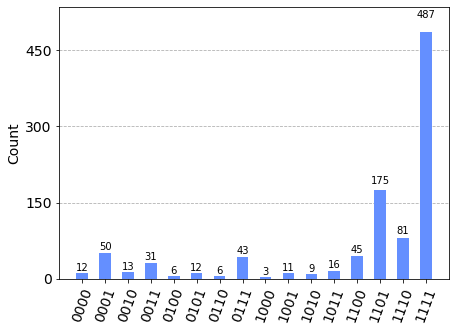

In [28]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [29]:
# QEM
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

In [30]:
qem_meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(qem_meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [31]:
# cal_results = aer_sim.run(qem_meas_calibs, shots=10000).result()
# meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

In [32]:
qem_meas_filter = qem_meas_fitter.filter

mitigated_results = qem_meas_filter.apply(realqc_results)
mitigated_counts = mitigated_results.get_counts()

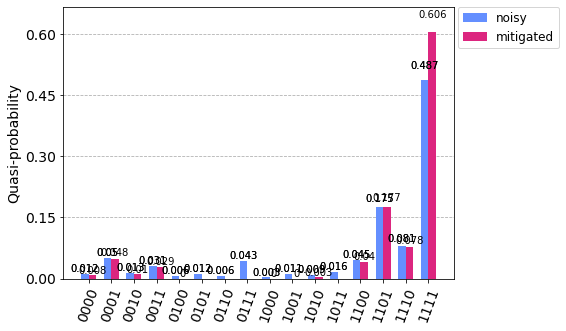

In [33]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [34]:
# GEM

In [35]:
# not calibrating ancilla
# depends on the concrete DJ circuit. this time: x on 1 and 2

dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)
dj_left4 = QuantumCircuit(n)
dj_left5 = QuantumCircuit(n)
dj_left6 = QuantumCircuit(n)
dj_left7 = QuantumCircuit(n)
dj_left8 = QuantumCircuit(n)
dj_left9 = QuantumCircuit(n)
dj_left10 = QuantumCircuit(n)
dj_left11 = QuantumCircuit(n)
dj_left12 = QuantumCircuit(n)
dj_left13 = QuantumCircuit(n)
dj_left14 = QuantumCircuit(n)
dj_left15 = QuantumCircuit(n)

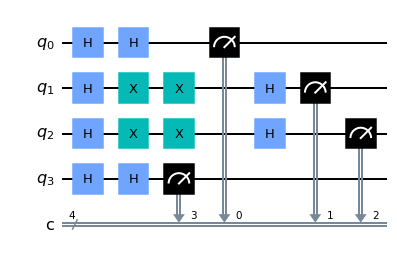

In [36]:
dj_left0.h(0)
dj_left0.h(0)

dj_left0.h(1)
dj_left0.x(1)
dj_left0.x(1)
dj_left0.h(1)

dj_left0.h(2)
dj_left0.x(2)
dj_left0.x(2)
dj_left0.h(2)

dj_left0.h(3)
dj_left0.h(3)
dj_left0.measure([0,1,2,3], [0,1,2,3])
dj_left0.draw()

/tmp/ipykernel_1502/4218642948.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left1 += dj_left0


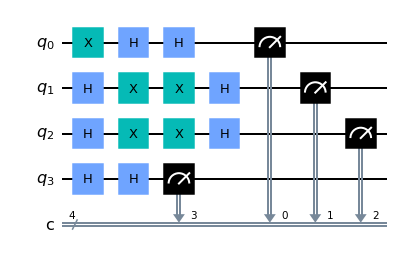

In [37]:
dj_left1.x(0)
dj_left1 += dj_left0
dj_left1.draw()

/tmp/ipykernel_1502/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


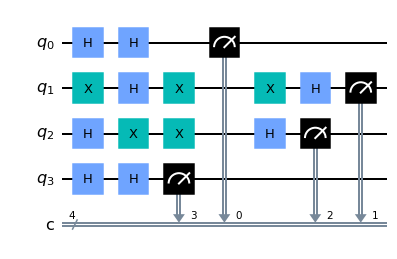

In [38]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_1502/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


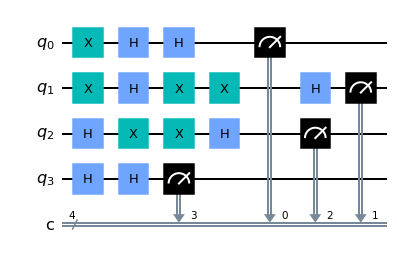

In [39]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

/tmp/ipykernel_1502/264572622.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left4 += dj_left0


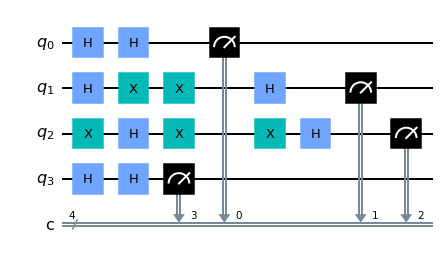

In [40]:
dj_left4.x(2)
dj_left4 += dj_left0
dj_left4.draw()

/tmp/ipykernel_1502/2497025790.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left5 += dj_left0


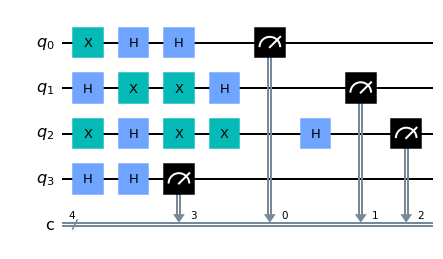

In [41]:
dj_left5.x(2)
dj_left5.x(0)
dj_left5 += dj_left0
dj_left5.draw()

/tmp/ipykernel_1502/2426855407.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left6 += dj_left0


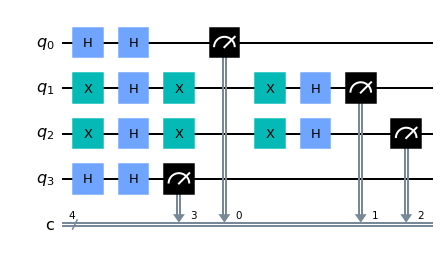

In [42]:
dj_left6.x(2)
dj_left6.x(1)
dj_left6 += dj_left0
dj_left6.draw()

/tmp/ipykernel_1502/778788731.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left7 += dj_left0


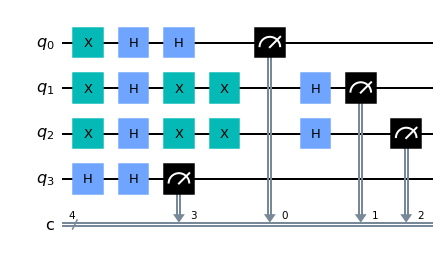

In [43]:
dj_left7.x(2)
dj_left7.x(1)
dj_left7.x(0)
dj_left7 += dj_left0
dj_left7.draw()

/tmp/ipykernel_1502/989489376.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left8 += dj_left0


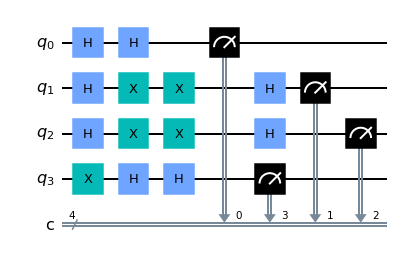

In [44]:
dj_left8.x(3)
dj_left8 += dj_left0
dj_left8.draw()

/tmp/ipykernel_1502/209537080.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left9 += dj_left0


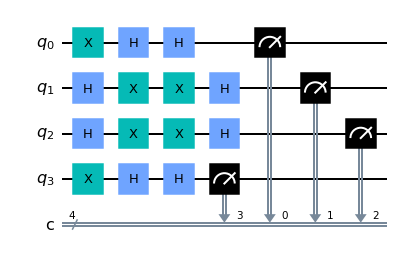

In [45]:
dj_left9.x(3)
dj_left9.x(0)
dj_left9 += dj_left0
dj_left9.draw()

/tmp/ipykernel_1502/2470987004.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left10 += dj_left0


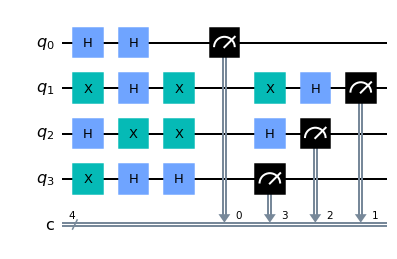

In [46]:
dj_left10.x(3)
dj_left10.x(1)
dj_left10 += dj_left0
dj_left10.draw()

/tmp/ipykernel_1502/4258748235.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left11 += dj_left0


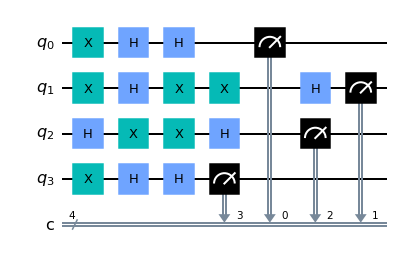

In [47]:
dj_left11.x(3)
dj_left11.x(1)
dj_left11.x(0)
dj_left11 += dj_left0
dj_left11.draw()

/tmp/ipykernel_1502/4044102656.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left12 += dj_left0


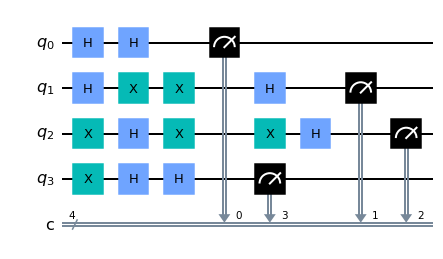

In [48]:
dj_left12.x(3)
dj_left12.x(2)
dj_left12 += dj_left0
dj_left12.draw()

/tmp/ipykernel_1502/1494147891.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left13 += dj_left0


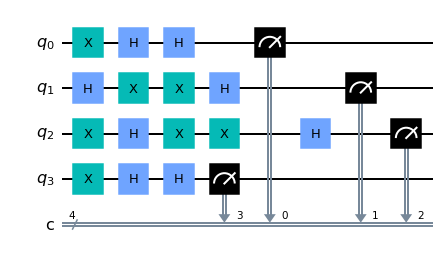

In [49]:
dj_left13.x(3)
dj_left13.x(2)
dj_left13.x(0)
dj_left13 += dj_left0
dj_left13.draw()

/tmp/ipykernel_1502/3820195286.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left14 += dj_left0


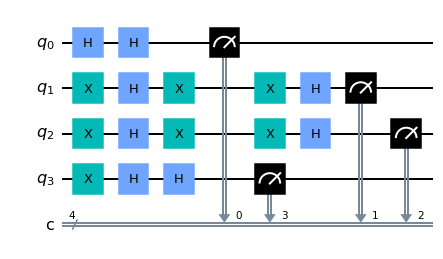

In [50]:
dj_left14.x(3)
dj_left14.x(2)
dj_left14.x(1)
dj_left14 += dj_left0
dj_left14.draw()

/tmp/ipykernel_1502/1035582658.py:5: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left15 += dj_left0


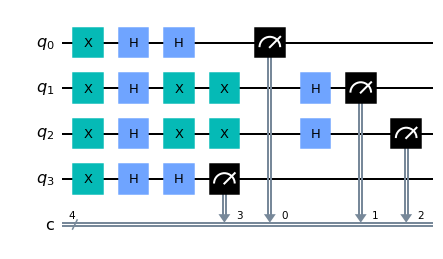

In [51]:
dj_left15.x(3)
dj_left15.x(2)
dj_left15.x(1)
dj_left15.x(0)
dj_left15 += dj_left0
dj_left15.draw()

In [52]:
meas_calibs1 = [dj_left0, dj_left1, dj_left2, dj_left3, dj_left4, dj_left5, dj_left6, dj_left7, dj_left8, dj_left9, dj_left10, dj_left11, dj_left12, dj_left13, dj_left14, dj_left15]
print(len(meas_calibs1))

16


In [53]:
# t_qc = transpile(meas_calibs1, aer_sim)
# qobj = assemble(t_qc, shots=10000)
# results = aer_sim.run(qobj, shots=10000).result()
# result_counts = results.get_counts()
# print(result_counts)

In [54]:
t_qc = transpile(meas_calibs1, real_backend)
qobj = assemble(t_qc, shots=10000)
real_results_left = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_1502/3062128249.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  real_results_left = real_backend.run(qobj, shots=10000).result()


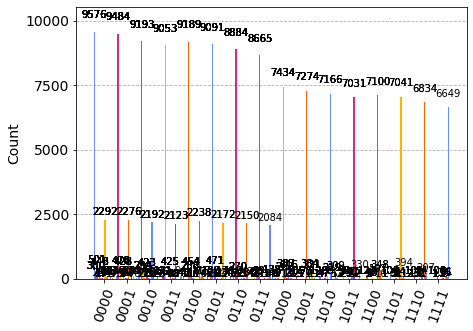

In [55]:
real_counts_left = real_results_left.get_counts()
plot_histogram(real_counts_left)

In [56]:
ls = []
for qc in meas_calibs1:
     counts = real_results_left.get_counts(qc)
     this_array = np.array([counts.get('0000') or 0, counts.get('0001') or 0, counts.get('0010') or 0, counts.get('0011') or 0 , counts.get('0100') or 0, counts.get('0101') or 0, counts.get('0110') or 0, counts.get('0111') or 0, counts.get('1000') or 0, counts.get('1001') or 0, counts.get('1010') or 0, counts.get('1011') or 0, counts.get('1100') or 0, counts.get('1101') or 0, counts.get('1110') or 0, counts.get('1111') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
     # np.append(array, this_array, axis=1)
array = np.array(ls)
# print(array)
array_t_left = np.transpose(array)
print(array_t_left)

[9.576e-01 1.180e-02 1.140e-02 3.000e-04 4.800e-03 0.000e+00 0.000e+00
 0.000e+00 1.380e-02 2.000e-04 1.000e-04 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[3.000e-02 9.484e-01 2.000e-04 5.600e-03 1.000e-04 4.600e-03 0.000e+00
 0.000e+00 3.000e-04 1.050e-02 0.000e+00 2.000e-04 0.000e+00 1.000e-04
 0.000e+00 0.000e+00]
[5.010e-02 5.000e-04 9.193e-01 1.210e-02 2.000e-04 0.000e+00 4.600e-03
 2.000e-04 6.000e-04 0.000e+00 1.200e-02 2.000e-04 0.000e+00 0.000e+00
 2.000e-04 0.000e+00]
[2.300e-03 4.780e-02 2.940e-02 9.053e-01 0.000e+00 2.000e-04 1.000e-04
 4.200e-03 0.000e+00 5.000e-04 4.000e-04 9.800e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[4.480e-02 5.000e-04 7.000e-04 0.000e+00 9.189e-01 1.000e-02 1.190e-02
 1.000e-04 7.000e-04 0.000e+00 0.000e+00 0.000e+00 1.230e-02 0.000e+00
 1.000e-04 0.000e+00]
[1.700e-03 4.280e-02 0.000e+00 4.000e-04 2.880e-02 9.091e-01 2.000e-04
 6.000e-03 0.000e+00 1.000e-04 0.000e+00 0.000e+00 2.000e-04 1.060e-02
 0.000e+00 1.000e-04]
[1.900e-03 0.000

In [57]:
array_to_latex(array_t_left)

<IPython.core.display.Latex object>

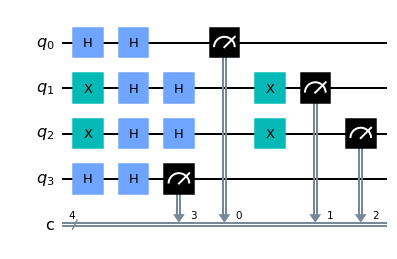

In [58]:
dj_right0 = QuantumCircuit(n,n)
dj_right1 = QuantumCircuit(n) 
dj_right2 = QuantumCircuit(n)
dj_right3 = QuantumCircuit(n)
dj_right4 = QuantumCircuit(n)
dj_right5 = QuantumCircuit(n)
dj_right6 = QuantumCircuit(n)
dj_right7 = QuantumCircuit(n)
dj_right8 = QuantumCircuit(n)
dj_right9 = QuantumCircuit(n)
dj_right10 = QuantumCircuit(n)
dj_right11 = QuantumCircuit(n)
dj_right12 = QuantumCircuit(n)
dj_right13 = QuantumCircuit(n)
dj_right14 = QuantumCircuit(n)
dj_right15 = QuantumCircuit(n)

dj_right0.x(1)
dj_right0.x(2)
dj_right0.h(1)
dj_right0.h(2)
dj_right0.h(1)
dj_right0.h(2)
dj_right0.x(1)
dj_right0.x(2)
dj_right0.h(0)
dj_right0.h(0)
dj_right0.h(3)
dj_right0.h(3)

dj_right0.measure([0,1,2,3], [0,1,2,3])
dj_right0.draw()

/tmp/ipykernel_1502/1762657075.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right1 += dj_right0


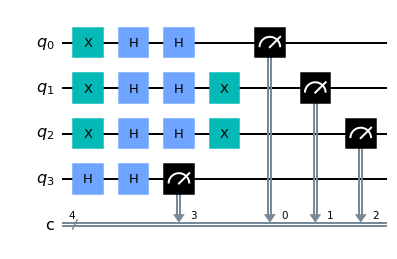

In [59]:
dj_right1.x(0)

dj_right1 += dj_right0

dj_right1.draw()

/tmp/ipykernel_1502/1107241932.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right2 += dj_right0


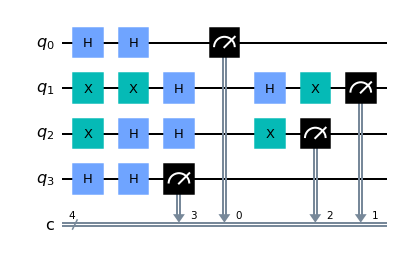

In [60]:
dj_right2.x(1)
dj_right2 += dj_right0
dj_right2.draw()

/tmp/ipykernel_1502/2247627861.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right3 += dj_right0


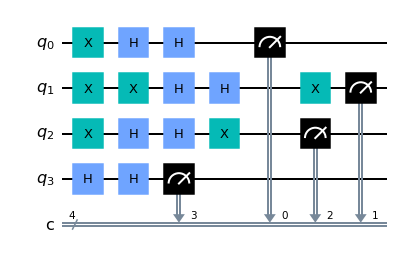

In [61]:
dj_right3.x(0)
dj_right3.x(1)
dj_right3 += dj_right0
dj_right3.draw()

/tmp/ipykernel_1502/35910541.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right4 += dj_right0


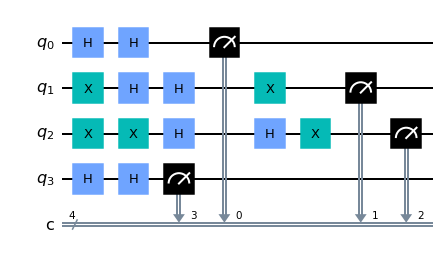

In [62]:
dj_right4.x(2)
dj_right4 += dj_right0
dj_right4.draw()

/tmp/ipykernel_1502/1744533513.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right5 += dj_right0


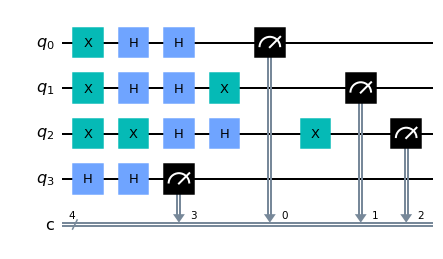

In [63]:
dj_right5.x(2)
dj_right5.x(0)
dj_right5 += dj_right0
dj_right5.draw()

/tmp/ipykernel_1502/1654595449.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right6 += dj_right0


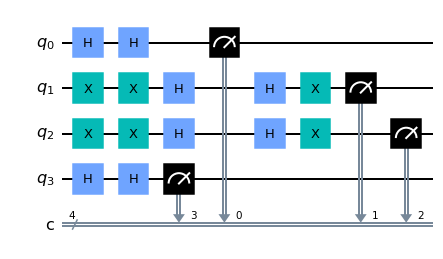

In [64]:
dj_right6.x(2)
dj_right6.x(1)
dj_right6 += dj_right0
dj_right6.draw()

/tmp/ipykernel_1502/611483946.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right7 += dj_right0


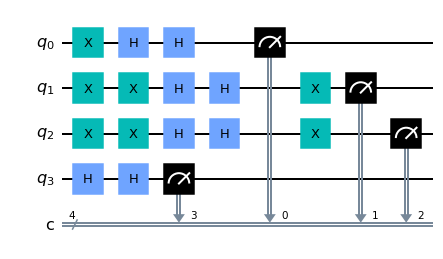

In [65]:
dj_right7.x(2)
dj_right7.x(1)
dj_right7.x(0)
dj_right7 += dj_right0
dj_right7.draw()

/tmp/ipykernel_1502/3964056886.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right8 += dj_right0


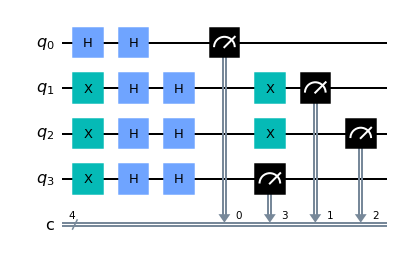

In [66]:
dj_right8.x(3)
dj_right8 += dj_right0
dj_right8.draw()

/tmp/ipykernel_1502/3828651180.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right9 += dj_right0


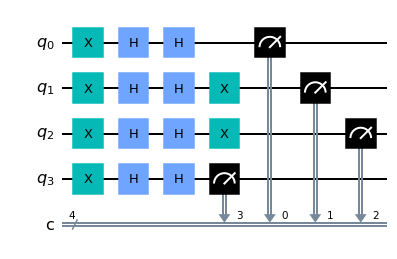

In [67]:
dj_right9.x(3)
dj_right9.x(0)
dj_right9 += dj_right0
dj_right9.draw()

/tmp/ipykernel_1502/902577939.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right10 += dj_right0


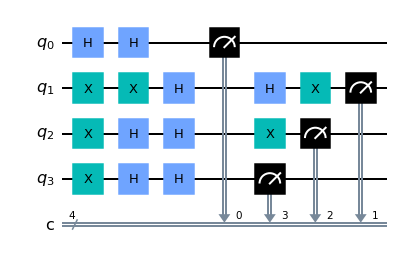

In [68]:
dj_right10.x(3)
dj_right10.x(1)
dj_right10 += dj_right0
dj_right10.draw()

/tmp/ipykernel_1502/639014280.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right11 += dj_right0


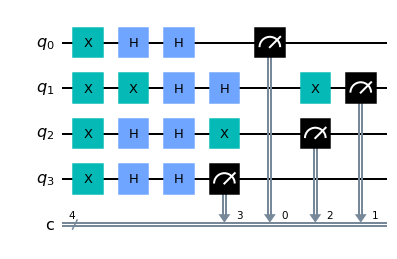

In [69]:
dj_right11.x(3)
dj_right11.x(1)
dj_right11.x(0)
dj_right11 += dj_right0
dj_right11.draw()

/tmp/ipykernel_1502/1174871471.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right12 += dj_right0


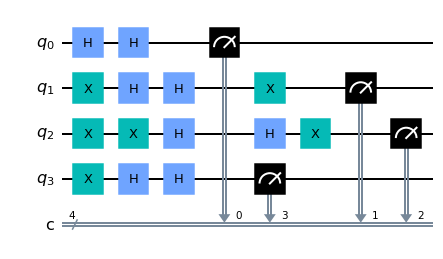

In [70]:
dj_right12.x(3)
dj_right12.x(2)
dj_right12 += dj_right0
dj_right12.draw()

/tmp/ipykernel_1502/3176146865.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right13 += dj_right0


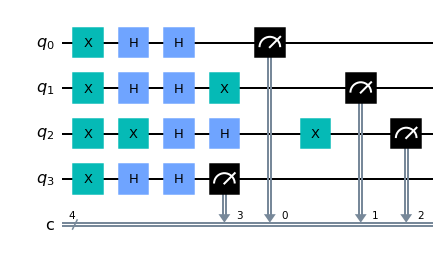

In [71]:
dj_right13.x(3)
dj_right13.x(2)
dj_right13.x(0)
dj_right13 += dj_right0
dj_right13.draw()

/tmp/ipykernel_1502/631145694.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right14 += dj_right0


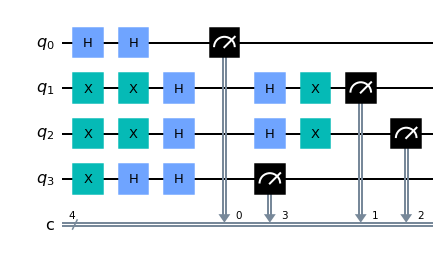

In [72]:
dj_right14.x(3)
dj_right14.x(2)
dj_right14.x(1)
dj_right14 += dj_right0
dj_right14.draw()

/tmp/ipykernel_1502/804146584.py:5: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right15 += dj_right0


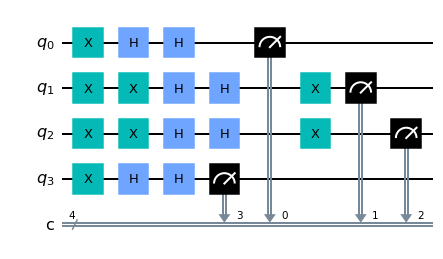

In [73]:
dj_right15.x(3)
dj_right15.x(2)
dj_right15.x(1)
dj_right15.x(0)
dj_right15 += dj_right0
dj_right15.draw()

In [75]:
meas_calibs2 = [dj_right0, dj_right1, dj_right2, dj_right3, dj_right4, dj_right5, dj_right6, dj_right7, dj_right8, dj_right9, dj_right10, dj_right11, dj_right12, dj_right13, dj_right14, dj_right15]
print(len(meas_calibs2))

16


In [76]:
t_qc = transpile(meas_calibs2, real_backend)
qobj = assemble(t_qc, shots=10000)
results_right = real_backend.run(qobj, shots=10000).result()

In [77]:
result_counts_right = results_right.get_counts()
print(result_counts_right)

[{'0000': 9675, '0001': 93, '0010': 87, '0011': 1, '0100': 50, '1000': 91, '1001': 2, '1010': 1}, {'0000': 338, '0001': 9463, '0010': 5, '0011': 65, '0100': 3, '0101': 39, '1000': 3, '1001': 84}, {'0000': 462, '0001': 6, '0010': 9294, '0011': 92, '0110': 42, '1000': 6, '1010': 96, '1011': 1, '1110': 1}, {'0000': 16, '0001': 424, '0010': 326, '0011': 9107, '0110': 3, '0111': 48, '1011': 76}, {'0000': 520, '0001': 8, '0010': 2, '0100': 9198, '0101': 98, '0110': 78, '1000': 3, '1100': 92, '1110': 1}, {'0000': 11, '0001': 466, '0011': 1, '0100': 284, '0101': 9090, '0110': 1, '0111': 45, '1001': 6, '1100': 1, '1101': 93, '1111': 2}, {'0000': 17, '0001': 1, '0010': 470, '0011': 3, '0100': 433, '0101': 4, '0110': 8878, '0111': 92, '1010': 4, '1100': 5, '1110': 93}, {'0001': 15, '0010': 13, '0011': 443, '0100': 14, '0101': 413, '0110': 293, '0111': 8710, '1010': 1, '1011': 3, '1101': 7, '1110': 2, '1111': 86}, {'0000': 1245, '0001': 18, '0010': 11, '0100': 8, '1000': 8543, '1001': 81, '1010': 

In [79]:
ls = []
for qc in meas_calibs2:
     counts = results_right.get_counts(qc)
     this_array = np.array([counts.get('0000') or 0, counts.get('0001') or 0, counts.get('0010') or 0, counts.get('0011') or 0 , counts.get('0100') or 0, counts.get('0101') or 0, counts.get('0110') or 0, counts.get('0111') or 0, counts.get('1000') or 0, counts.get('1001') or 0, counts.get('1010') or 0, counts.get('1011') or 0, counts.get('1100') or 0, counts.get('1101') or 0, counts.get('1110') or 0, counts.get('1111') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
     # np.append(array, this_array, axis=1)
array = np.array(ls)
# print(array)
array_t_right = np.transpose(array)
print(array_t_right)

[9.675e-01 9.300e-03 8.700e-03 1.000e-04 5.000e-03 0.000e+00 0.000e+00
 0.000e+00 9.100e-03 2.000e-04 1.000e-04 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[3.380e-02 9.463e-01 5.000e-04 6.500e-03 3.000e-04 3.900e-03 0.000e+00
 0.000e+00 3.000e-04 8.400e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[4.620e-02 6.000e-04 9.294e-01 9.200e-03 0.000e+00 0.000e+00 4.200e-03
 0.000e+00 6.000e-04 0.000e+00 9.600e-03 1.000e-04 0.000e+00 0.000e+00
 1.000e-04 0.000e+00]
[1.600e-03 4.240e-02 3.260e-02 9.107e-01 0.000e+00 0.000e+00 3.000e-04
 4.800e-03 0.000e+00 0.000e+00 0.000e+00 7.600e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[5.200e-02 8.000e-04 2.000e-04 0.000e+00 9.198e-01 9.800e-03 7.800e-03
 0.000e+00 3.000e-04 0.000e+00 0.000e+00 0.000e+00 9.200e-03 0.000e+00
 1.000e-04 0.000e+00]
[1.10e-03 4.66e-02 0.00e+00 1.00e-04 2.84e-02 9.09e-01 1.00e-04 4.50e-03
 0.00e+00 6.00e-04 0.00e+00 0.00e+00 1.00e-04 9.30e-03 0.00e+00 2.00e-04]
[1.700e-03 1.000e-04 4.700e-02 3.

In [80]:
array_to_latex(array_t_right)

<IPython.core.display.Latex object>

In [81]:
array_sum = (array_t_left + array_t_right) / 2
array_to_latex(array_sum)

<IPython.core.display.Latex object>

In [82]:
import scipy.linalg as la
array_inv = la.inv(array_sum)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [83]:
counts = realqc_results.get_counts()

In [84]:
result_array = np.array([counts.get('0000') or 0, counts.get('0001') or 0, counts.get('0010') or 0, counts.get('0011') or 0 , counts.get('0100') or 0, counts.get('0101') or 0, counts.get('0110') or 0, counts.get('0111') or 0, counts.get('1000') or 0, counts.get('1001') or 0, counts.get('1010') or 0, counts.get('1011') or 0, counts.get('1100') or 0, counts.get('1101') or 0, counts.get('1110') or 0, counts.get('1111') or 0])
result_array = result_array/1000

In [85]:
result_array

array([0.012, 0.05 , 0.013, 0.031, 0.006, 0.012, 0.006, 0.043, 0.003,
       0.011, 0.009, 0.016, 0.045, 0.175, 0.081, 0.487])

In [86]:
mitigated = np.dot(array_inv, result_array)

In [93]:
mitigated

array([ 9.71903459e-03,  4.98286902e-02,  1.13910188e-02,  3.35813389e-02,
       -3.38317708e-03, -2.69024472e-02, -1.19392225e-02, -7.28724921e-02,
        1.69313169e-04,  3.03737643e-03,  6.59951278e-03, -1.18032258e-02,
        4.84872908e-02,  1.98158634e-01,  8.87166008e-02,  6.77211754e-01])

In [88]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [94]:
normal

array([0.11010967, 0.1635832 , 0.11233873, 0.1419225 , 0.09264201,
       0.06128651, 0.08123523, 0.        , 0.09737814, 0.10120179,
       0.10595077, 0.08141654, 0.16179487, 0.36133425, 0.21542793,
       1.        ])

In [90]:
def Normalize(arr):
    return arr/sum(arr)

In [91]:
new_normal = Normalize(mitigated)

In [95]:
new_normal

array([ 9.71903459e-03,  4.98286902e-02,  1.13910188e-02,  3.35813389e-02,
       -3.38317708e-03, -2.69024472e-02, -1.19392225e-02, -7.28724921e-02,
        1.69313169e-04,  3.03737643e-03,  6.59951278e-03, -1.18032258e-02,
        4.84872908e-02,  1.98158634e-01,  8.87166008e-02,  6.77211754e-01])